In [95]:
import torch
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [96]:
df = pd.read_csv("../data/processed/OUT20_new_closed_loop_FIXED_2.csv")

In [97]:
df

,Timestamp,T1,T2,T3,T4,T5,I,V,PID set value,DMC set value,data set-value,FLU,FRU,FLB,FRB,HL,HR
0,0.000000,3418,3187,3512,2368,2293,950,960,4000,4500,1,500,500,0,0,1000,987
1,0.100021,3418,3187,3512,2368,2293,950,960,4000,4500,1,500,500,0,0,1000,987
2,0.200022,3418,3187,3512,2368,2293,950,960,4000,4500,1,500,500,0,0,1000,987
3,0.300034,3418,3187,3512,2368,2293,950,960,4000,4500,1,500,500,0,0,1000,987
4,0.400981,3418,3187,3512,2368,2293,950,960,4000,4500,1,500,500,0,0,1000,987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841787,84178.701001,3006,3106,3287,2537,2350,45,970,2270,2350,0,500,500,0,0,0,0
841788,84178.800978,3006,3106,3287,2537,2350,45,970,2270,2350,0,500,500,0,0,0,0
841789,84178.900978,3006,3106,3287,2537,2350,45,970,2270,2350,0,500,500,0,0,0,0
841790,84179.000991,3006,3106,3287,2537,2350,45,970,2270,2350,0,500,500,0,0,0,0


In [98]:
df["PID set value"].value_counts()

PID set value
2270    253014
4000    252748
4500    168001
3500     84001
3000     84000
971         28
Name: count, dtype: int64

In [99]:
df["DMC set value"].value_counts()

DMC set value
2350    252972
4000    252002
4500    168789
3500     84001
4300     84000
2270        28
Name: count, dtype: int64

In [100]:
df.drop(["PID set value", "DMC set value", "data set-value"], axis=1, inplace=True)

In [101]:
df

,Timestamp,T1,T2,T3,T4,T5,I,V,FLU,FRU,FLB,FRB,HL,HR
0,0.000000,3418,3187,3512,2368,2293,950,960,500,500,0,0,1000,987
1,0.100021,3418,3187,3512,2368,2293,950,960,500,500,0,0,1000,987
2,0.200022,3418,3187,3512,2368,2293,950,960,500,500,0,0,1000,987
3,0.300034,3418,3187,3512,2368,2293,950,960,500,500,0,0,1000,987
4,0.400981,3418,3187,3512,2368,2293,950,960,500,500,0,0,1000,987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841787,84178.701001,3006,3106,3287,2537,2350,45,970,500,500,0,0,0,0
841788,84178.800978,3006,3106,3287,2537,2350,45,970,500,500,0,0,0,0
841789,84178.900978,3006,3106,3287,2537,2350,45,970,500,500,0,0,0,0
841790,84179.000991,3006,3106,3287,2537,2350,45,970,500,500,0,0,0,0


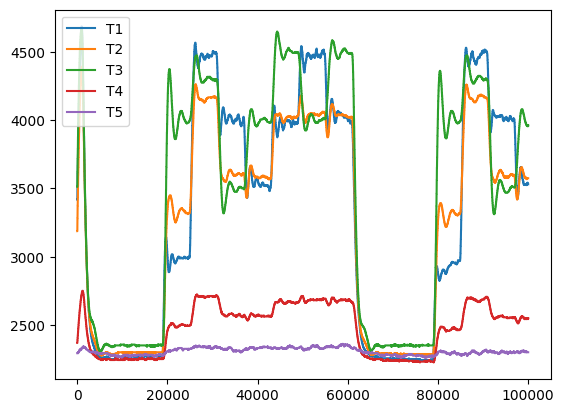

In [102]:
plt.plot(df["T1"][:100000])
plt.plot(df["T2"][:100000])
plt.plot(df["T3"][:100000])
plt.plot(df["T4"][:100000])
plt.plot(df["T5"][:100000])
plt.legend(["T1", "T2", "T3", "T4", "T5"], loc="upper left")

In [103]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [104]:
class ExperimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def __len__(self):
        return len(self.X)

In [105]:
df.keys()

Index(['Timestamp', 'T1', 'T2', 'T3', 'T4', 'T5', 'I', 'V', 'FLU', 'FRU',
       'FLB', 'FRB', 'HL', 'HR'],
      dtype='object')

In [106]:
X_train, X_test, y_train, y_test = train_test_split(
    df[["I", "V", "FLU", "FRU", "FLB", "FRB", "HL", "HR"]],
    df[["T1", "T2", "T3", "T4", "T5"]],
    test_size=0.2,
    random_state=42,
)

In [13]:
train_dataset = pd.concat([X_train, y_train], axis=1)
valid_dataset = pd.concat([X_test, y_test], axis=1)

In [14]:
train_dataset.dtypes

I      int64
V      int64
FLU    int64
FRU    int64
FLB    int64
FRB    int64
HL     int64
HR     int64
T1     int64
T2     int64
T3     int64
T4     int64
T5     int64
dtype: object

In [15]:
train_dataset.iloc[:, 0:-5].dtypes

I      int64
V      int64
FLU    int64
FRU    int64
FLB    int64
FRB    int64
HL     int64
HR     int64
dtype: object

In [16]:
train_dataset = ExperimentDataset(
    train_dataset.iloc[:, 0:-5].values, train_dataset.iloc[:, -5:].values
)

# Linear Regression

In [17]:
print(X_train.shape, y_train.shape)

(673433, 8) (673433, 5)


In [18]:
linear_regression_model = LinearRegression()

In [19]:
linear_regression_model.fit(X_train, y_train)

LinearRegression()

In [20]:
linear_regression_model.score(X_train, y_train)

0.6682259588876137

In [21]:
predicted_values = linear_regression_model.predict(X_test)

In [22]:
mse = mean_squared_error(y_test, predicted_values)

In [23]:
mse

np.float64(70374.8157313134)

In [24]:
predicted_values.shape
predicted_values[:, 0]
y_test.values[:, 0]

array([4506, 4481, 3275, ..., 3562, 4050, 2987])

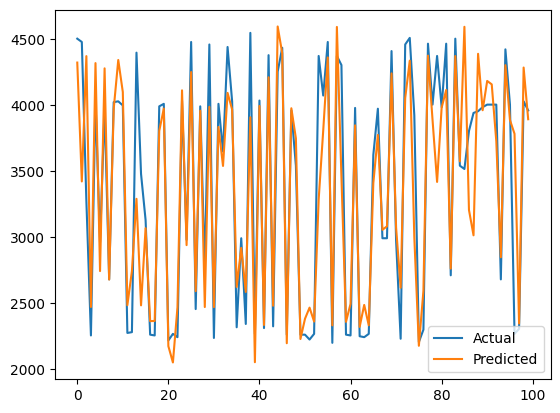

In [25]:
plt.plot(y_test.values[:100, 0])
plt.plot(predicted_values[:100, 0])
plt.legend(["Actual", "Predicted"])

# LSTM

In [50]:
import torch.nn as nn
import torch
import torch.optim as optim
import torch.utils.data as data
import numpy as np

In [124]:
class SequentialDataset(Dataset):
    def __init__(self, X, y, sequence_length = 10):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.sequence_length = sequence_length

    def __getitem__(self, idx):
        if idx > self.sequence_length - 1:
            idx_start = idx - self.sequence_length + 1
            x = self.X[idx_start:(idx+1) : ]
        else:
            padding = self.X[0].repeat(self.sequence_length - idx -1, 1)
            x = self.X[0:(idx+1):]
            x = torch.cat((padding, x), dim=0)
        return x, self.y[idx]

    def __len__(self):
        return len(self.X)

In [134]:
train_sequential_dataset = SequentialDataset(
    X_train.values, y_train.values, sequence_length =10
)
test_sequential_dataset =  SequentialDataset(
    X_test.values, y_test.values, sequence_length=10
)

In [126]:
train_sequential_dataset[0][0].shape


torch.Size([10, 8])

In [166]:
class LSTMNet(nn.Module):
    def __init__(
        self, input_size, hidden_size, num_layers, seq_length, out_size
    ):
        super(LSTMNet, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length
        self.input_size = input_size
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, out_size)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc1(out[:, -1, :])
        out = self.fc2(out)
        return out

In [167]:
print(X_train.shape[1])

8


In [168]:
input_size = X_train.shape[1]
hidden_size = 1028
num_layers = 1 
out_size = y_train.shape[1]
seq_length = 10

In [169]:
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)

In [170]:
model = LSTMNet(input_size=input_size, hidden_size=hidden_size,
             num_layers=num_layers, out_size=out_size, seq_length=seq_length)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

In [171]:
X_train

tensor([[630., 962., 500.,  ...,   0., 603., 747.],
        [735., 962., 500.,  ...,   0., 977., 503.],
        [498., 963., 500.,  ...,   0., 665., 360.],
        ...,
        [ 65., 970., 500.,  ...,   0.,   0.,  54.],
        [ 49., 971., 500.,  ...,   0.,   0.,  42.],
        [ 44., 970., 500.,  ...,   0.,   0.,  16.]])

In [172]:
n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    print(epoch)
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # if epoch % 100 == 0:
    print(f"Epoch {epoch}/{n_epochs}, Loss: {running_loss / len(loader):.4f}")

    # if epoch % 100 == 0:
    # model.eval()
    # with torch.no_grad():
    #     y_train_pred = model(X_train)
    #     train_rmse = np.sqrt(loss_fn(y_train_pred, y_train))
    #     y_test_pred = model(X_test)
    #     test_rmse = np.sqrt(loss_fn(y_test_pred, y_test))
    # print(f"Epoch {epoch}: Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

0


RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors

In [173]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

In [174]:
def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches

In [175]:
train_loader = DataLoader(train_sequential_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_sequential_dataset, batch_size=256, shuffle=False)

In [177]:
# train_model(train_loader, model, loss_fn, optimizer=optimizer)

Train loss: 53910.6914923627


In [156]:
for ix_epoch in range(5):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_fn, optimizer=optimizer)


Epoch 0
---------
Train loss: 398027.5185053212
Epoch 1
---------
Train loss: 398062.04218928167
Epoch 2
---------
Train loss: 398095.11281356897
Epoch 3
---------
Train loss: 398074.4651985937
Epoch 4
---------
Train loss: 398048.04848441656


In [157]:
test_model(test_loader, model, loss_fn)

In [158]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

In [180]:
train_eval_loader = DataLoader(train_sequential_dataset, batch_size=256, shuffle=False)
test_eval_loader = DataLoader(train_sequential_dataset, batch_size=256, shuffle=False)

In [181]:
output = predict(train_eval_loader, model)

In [182]:
output

tensor([[3981.9543, 3915.6306, 4303.3208, 2613.2795, 2271.1421],
        [4301.9233, 4033.5659, 4208.3623, 2668.2761, 2290.4189],
        [3844.7585, 3642.7593, 3790.5969, 2568.5662, 2280.0044],
        ...,
        [2271.6614, 2324.0034, 2418.2483, 2230.7292, 2245.2166],
        [2269.8730, 2322.6287, 2416.7651, 2230.9502, 2245.9434],
        [2451.8418, 2477.7009, 2575.7039, 2286.2231, 2270.4248]])

In [183]:
output.shape

torch.Size([673433, 5])

In [184]:
train_dataset.y.shape

torch.Size([673433, 5])

In [185]:
import matplotlib.pyplot as plt

def visualize_predictions(y_actual, y_predicted):
    plt.figure(figsize=(15, 10))
    for i in range(y_actual.shape[1]):
        plt.subplot(3, 2, i + 1)
        plt.plot(y_actual[:, i], label="Actual")
        plt.plot(y_predicted[:, i], label="Predicted")
        plt.title(f"y{i+1}")
        plt.legend()
    plt.tight_layout()
    plt.show()

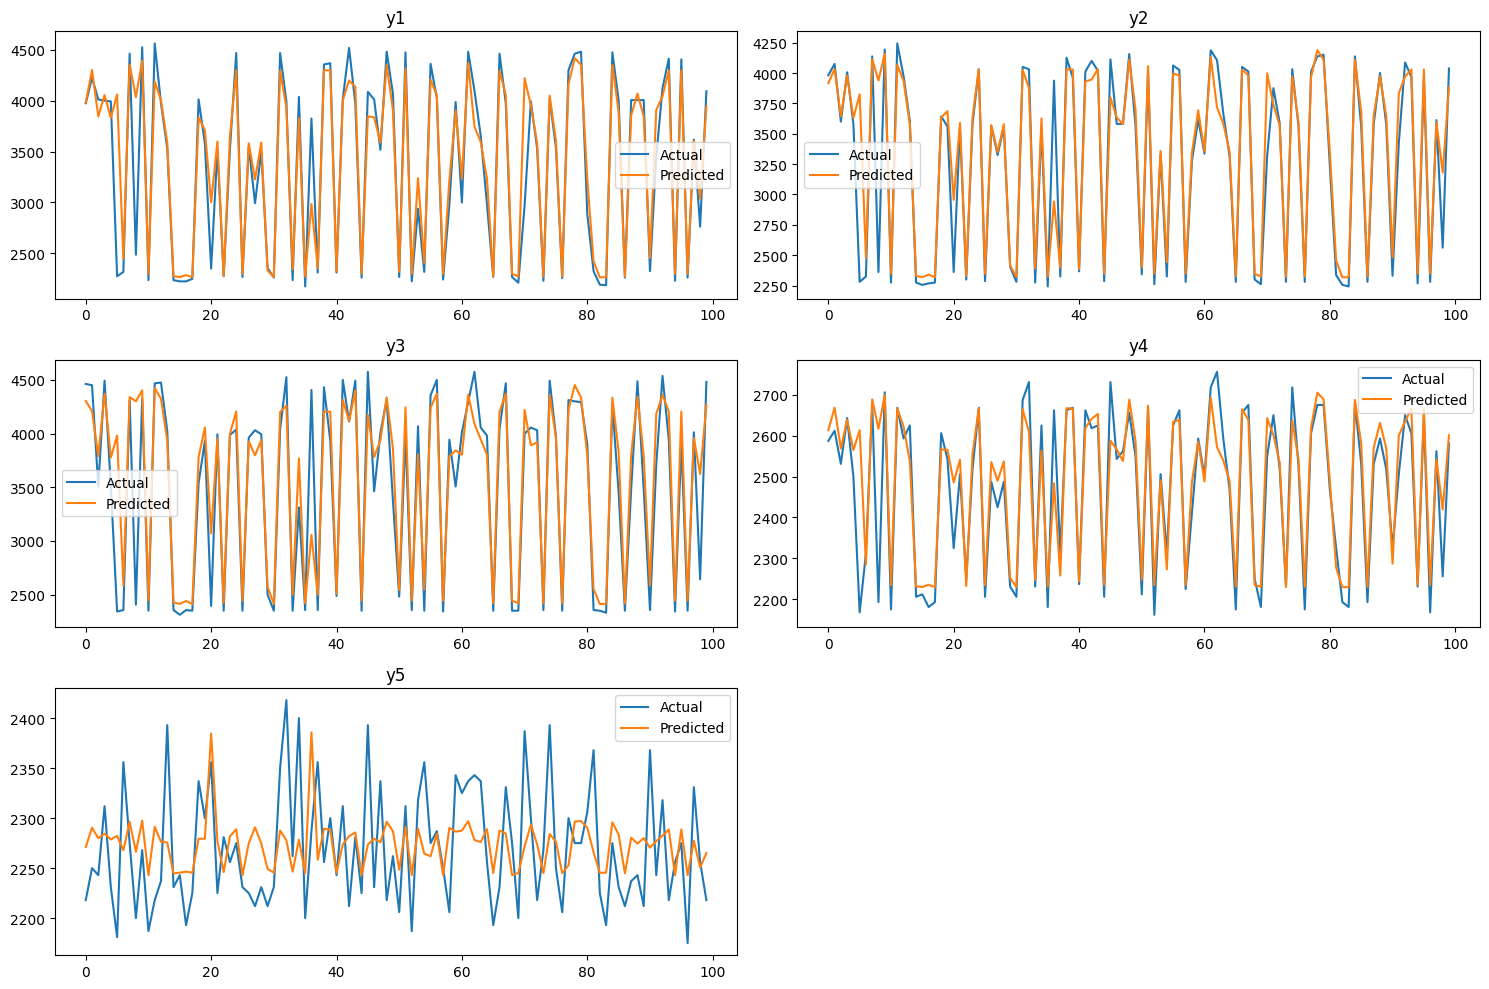

In [186]:
visualize_predictions(train_dataset.y[:100,:].numpy(), output[:100, :].detach().numpy())

In [187]:
print(type(loss_fn))

<class 'torch.nn.modules.loss.MSELoss'>


In [ ]:
# zaczac od algorytmów regulacji, sieci przejsc do braku nadzoru i kontrolowanie danych 